In [1]:
from __future__ import division, print_function

In [2]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [3]:
def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

In [4]:
def plot_result(x,y,x_data,y_data,yh,xp=None):    
    plt.figure(figsize=(12,6))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4,
                    label='Physics loss training locations')
    l = plt.legend(loc='upper right', frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.2, np.pi)
    plt.ylim(-1.5, 1.5)    
    plt.annotate("Training step: %i"%(i+1), 
             xy=(0, 1), 
             xycoords='axes fraction', 
             fontsize="xx-large", 
             color="k",
             ha='left', 
             va='top')
    plt.axis("off")

In [5]:
style = "https://raw.githubusercontent.com/nicoguaro/matplotlib_styles/master/styles/clean.mplstyle"

In [6]:
def style_plot(x, y, x_data, y_data, yh, xp=None):
    style = "https://raw.githubusercontent.com/nicoguaro/matplotlib_styles/master/styles/clean.mplstyle"
    with plt.style.context(style):        
        fig = plt.figure()
        ax = plt.subplot(111)
        plt.plot(x, y, label="Exact solution")
        if y_data is not None:            
            plt.scatter(x_data, y_data, label='Training data')
        if yh is not None:
            plt.plot(x, yh, marker='.', label="Neural network prediction")
        if xp is not None:
            plt.scatter(xp, -0*torch.ones_like(xp), label='Physics loss training locations')
        plt.annotate("Training step: %i"%(i+1), 
             xy=(0, 1), 
             xycoords='axes fraction', 
             fontsize="small", 
             color="k",
             ha='left', 
             va='top')
        plt.legend(loc='best')

**Main Problem**

In [7]:
def f_rhs(x):
   return -4*torch.sin(2 * x)

def exact_u(x):
    return torch.sin(2 * x)

def exact_u_singular(x):
  return x**0.7 * (x - torch.pi)

def f_singular_rhs(x):
  return -0.7 * 0.3 * (x**-1.3) * (x - torch.pi) + (0.7*x**-0.3) * (1) + (0.7 * x**-0.3)  

class TransformerEDP(nn.Module):    
    def __init__(self, input_dim, output_dim, num_layers, hidden_dim):
        super(TransformerEDP, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh()
        )
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=1, activation='relu'), 
            num_layers
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):        
        x = self.encoder(x)  
        output = self.transformer_encoder(x)  
        output = self.decoder(output)
        return output 

**Training Data**

torch.Size([1000, 1]) torch.Size([1000, 1])
torch.Size([15, 1]) torch.Size([15, 1])


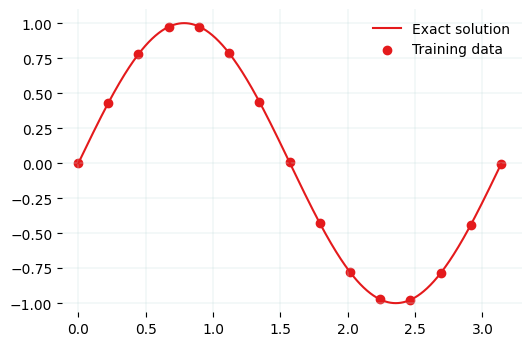

In [8]:
n_pts = 1000

x = np.array([np.pi/n_pts * i for i in range(n_pts)])
x = torch.tensor(x, dtype=torch.float32).view(-1, 1)
y = exact_u(x).view(-1, 1)
print(x.shape, y.shape)

num_samples = 15
indices = np.linspace(0, len(x)-1, num_samples, dtype=int)
x_data = x[indices]
y_data = y[indices]
print(x_data.shape, y_data.shape)

with plt.style.context(style):        
        fig = plt.figure()
        ax = plt.subplot(111)
        plt.plot(x, y, label="Exact solution")        
        plt.scatter(x_data, y_data, label='Training data')        
        plt.legend()
        plt.show()

### **Normal Encoder Transformer**

In [20]:
torch.manual_seed(123)
model = TransformerEDP(input_dim=1, output_dim=1, num_layers=2, hidden_dim=6)
model

TransformerEDP(
  (encoder): Sequential(
    (0): Linear(in_features=1, out_features=4, bias=True)
    (1): Tanh()
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
        )
        (linear1): Linear(in_features=4, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=4, bias=True)
        (norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): Sequential(
    (0): Linear(in_features=4, out_features=1, bias=True)
  )
)

**Params**

In [21]:
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters: {total_params}')

Total number of parameters: 37077


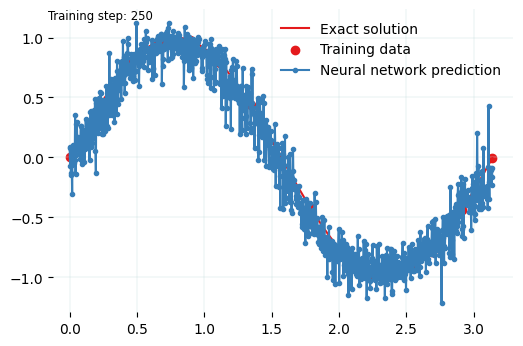

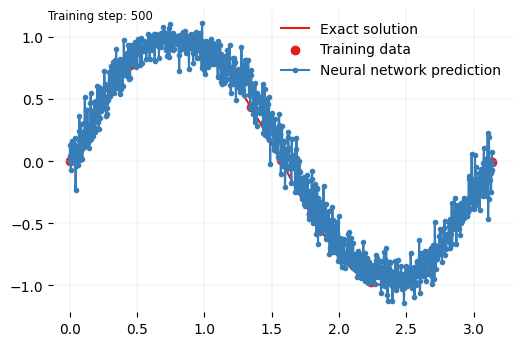

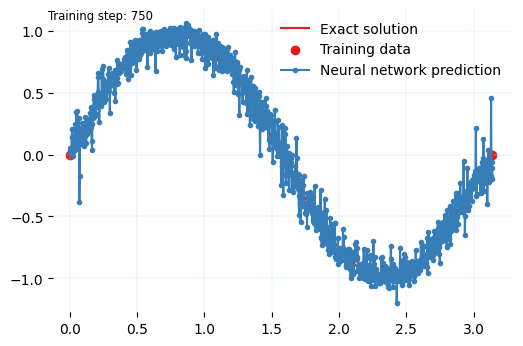

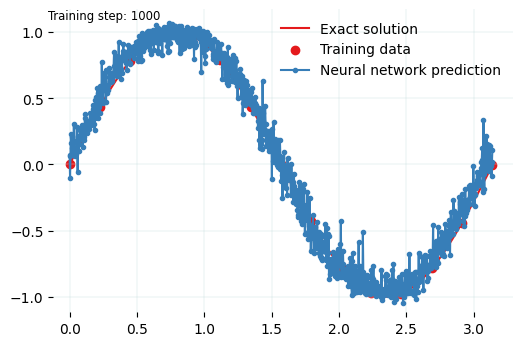

In [26]:
model = TransformerEDP(input_dim=1, output_dim=1, num_layers=2, hidden_dim=8)
n_iterations = 1000
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
files = []
for i in range(n_iterations):
    optimizer.zero_grad()
    yh = model(x_data)
    loss = torch.mean((yh-y_data)**2)
    loss.backward()
    optimizer.step()

    if (i+1) % 10 == 0:
        yh = model(x).detach()
        style_plot(x, y, x_data, y_data, yh)
        file = "plots/nn_%.8i.png"%(i+1)    
        plt.savefig(file, bbox_inches=None, pad_inches=0.5, dpi=100, facecolor="white")
        files.append(file)

    if (i+1) % 250 == 0: plt.show()
    else: plt.close("all")
save_gif_PIL("transformer_sen_data_gif.gif", files, fps=20, loop=0)

### **PITN**

Loss at iteration 50: 2.317046
Loss at iteration 100: 1.830961
Loss at iteration 150: 1.061103
Loss at iteration 200: 1.344379
Loss at iteration 250: 1.622631


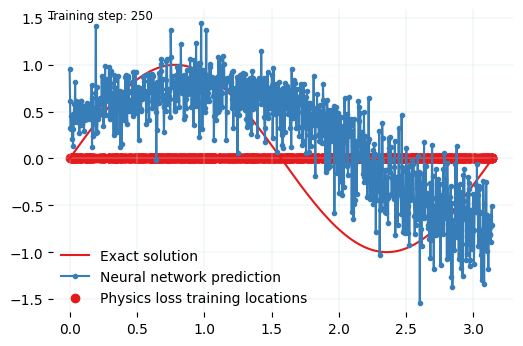

Loss at iteration 300: 2.282737
Loss at iteration 350: 1.109440
Loss at iteration 400: 1.194703
Loss at iteration 450: 0.868869
Loss at iteration 500: 0.899038


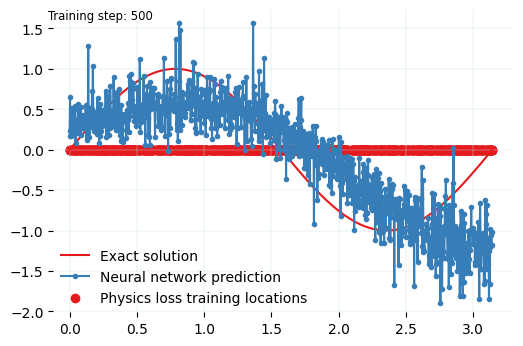

In [9]:
x_physics = torch.FloatTensor(2000,1).uniform_(0, np.pi).requires_grad_(True)
x_physics = x_physics.unsqueeze(0)
iterations = 500

torch.manual_seed(123)
model = TransformerEDP(input_dim=1, output_dim=1, num_layers=2, hidden_dim=8)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
files = []
losses = []
output_errors = []

for i in range(iterations):
    x_physics = torch.FloatTensor(n_pts,1).uniform_(0, np.pi).requires_grad_(True)
    optimizer.zero_grad()    

    yh = model(x_data)
    loss_data = torch.mean((yh-y_data)**2)
    
    # Physics loss
    yhp = model(x_physics)
    du = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]
    ddu = torch.autograd.grad(du, x_physics, torch.ones_like(du), create_graph=True)[0]
    error_PDE = torch.mean((ddu - f_rhs(x_physics))**2)
    bc = model(torch.tensor([np.pi]).unsqueeze(0))**2 + model(torch.tensor([0.]).unsqueeze(0))**2
    loss_physics = error_PDE + bc

    # Backpropagation
    loss = loss_data + loss_physics
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    # Calculo del error MSE 
    exact_function = exact_u(x_physics)
    predicted_function = model(x_physics).detach()
    error_between_arrays = exact_function - predicted_function
    output_error = torch.mean((error_between_arrays)**2)
    output_error /= torch.mean(exact_function**2)
    output_errors.append(output_error.item())

    if (i+1) % 50 == 0:
        print(f"Loss at iteration {i+1}: {loss.item():.6f}")

    if (i+1) % 10 == 0:

        yh = model(x).detach()
        xp = x_physics.detach()

        style_plot(x, y, x_data=None, y_data=None, yh=yh, xp=xp)

        file = "plots/pinn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches=None, pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)

        if (i+1) % 250 == 0: plt.show()
        else: plt.close("all")
save_gif_PIL("transformer_sen_physics_gif.gif", files, fps=20, loop=0)

**MSE Error**

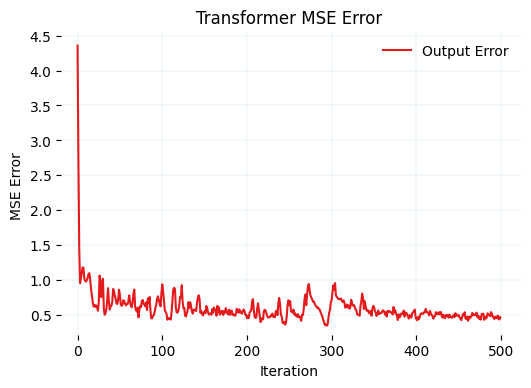

In [10]:
with plt.style.context(style):        
    fig = plt.figure()
    ax = plt.subplot(111)
    plt.title("Transformer MSE Error")
    plt.plot(output_errors, label="Output Error")
    plt.xlabel("Iteration")
    plt.ylabel('MSE Error')             
    plt.legend()
    
    # Guardar la gráfica
    plt.savefig('ffnn_sen_physics_error_mse.png', dpi=300, bbox_inches='tight')
    
    plt.show()

**Loss Function**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


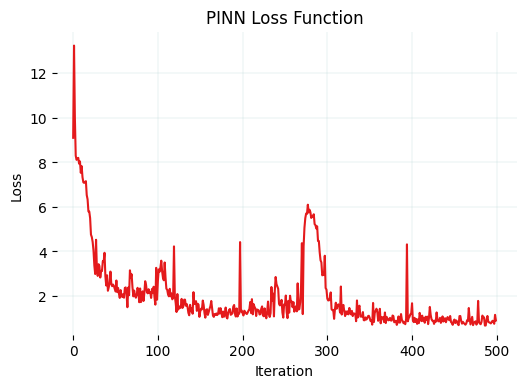

In [11]:
with plt.style.context(style):        
    fig = plt.figure()
    ax = plt.subplot(111)
    plt.title("PINN Loss Function")
    plt.plot(losses)
    plt.xlabel("Iteration")
    plt.ylabel('Loss')             
    plt.legend()
    
    # Guardar la gráfica
    plt.savefig('transformer_sen_physics_loss_function.png', dpi=300, bbox_inches='tight')
    
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


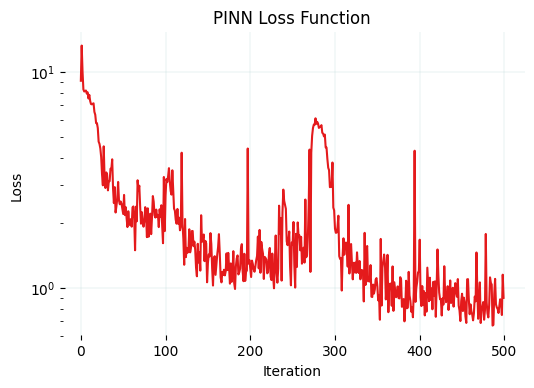

In [12]:
with plt.style.context(style):        
    fig = plt.figure()
    ax = plt.subplot(111)
    plt.title("PINN Loss Function")
    plt.semilogy(losses)  
    plt.xlabel("Iteration")
    plt.ylabel('Loss')             
    plt.legend()

    # Guardar la gráfica
    plt.savefig('transformer_sen_physics_semilogy_loss_function.png', dpi=300, bbox_inches='tight')

    plt.show()

##### **Error**

In [13]:
x_physics = torch.FloatTensor(n_pts,1).uniform_(0, np.pi).requires_grad_(True)

exact_function = exact_u(x_physics)
predicted_function = model(x_physics).detach()
error_between_arrays = exact_function - predicted_function

Mean Squared Error (MSE)

In [14]:
# Error relativo
output_error = torch.mean((error_between_arrays)**2)
output_error /= torch.mean(exact_function**2)
print(f"Output error: {output_error.item():.8f}")

Output error: 0.49086723


Max Error

In [15]:
max_error = torch.max(torch.abs(error_between_arrays))
max_error /= torch.max(torch.abs(exact_function))
print(f"Max error: {max_error.item():.8f}")

Max error: 1.74690878


Min Error

In [16]:
min_error = torch.min(torch.abs(error_between_arrays))
min_error /= torch.min(torch.abs(exact_function))
print(f"Min error: {min_error.item():.8f}")

Min error: 0.03398904


Avg Error

In [17]:
avg_error = torch.mean(torch.abs(error_between_arrays))
avg_error /= torch.mean(torch.abs(exact_function))
print(f"Avg error: {avg_error.item():.8f}")

Avg error: 0.63943160


**Save PITN model**

In [46]:
torch.save(model.state_dict(), "models/poisson1_pitn.pth")

In [47]:
model = TransformerEDP(input_dim=1, output_dim=1, num_layers=2, hidden_dim=12)
model.load_state_dict(torch.load("models/poisson1_pitn.pth"))

<All keys matched successfully>

In [48]:
model.eval()

TransformerEDP(
  (encoder): Sequential(
    (0): Linear(in_features=1, out_features=12, bias=True)
    (1): Tanh()
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=12, out_features=12, bias=True)
        )
        (linear1): Linear(in_features=12, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=12, bias=True)
        (norm1): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): Sequential(
    (0): Linear(in_features=12, out_features=1, bias=True)
  )
)